In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# Week 3: Sequence Modeling of Financial Time Series using LSTM

**Project:** Market Mood and Moves (WiDS 5.0)  
**Student:** Pranit Anand  
**Focus:** Temporal Modeling of Market Data  

---

## Notebook Objective

This notebook focuses on **sequence modeling** for financial time series using
**Long Short-Term Memory (LSTM)** networks.

The objective is to study how temporal dependencies in market data can be
modeled using recurrent architectures and how historical information influences
future predictions.

The emphasis of this notebook is on:
- Understanding **why temporal models are needed** in finance
- Constructing sequences using a sliding window approach
- Observing the behavior of LSTM models on market-style data

The notebook is intended as an exploratory and educational exercise rather than
a production-grade trading model.


In [2]:
class MarketDataset(Dataset):
    def __init__(self, features, targets, sequence_length=60):
        """
        features: numpy array of shape (N, num_features)
        targets: numpy array of shape (N,)
        sequence_length: lookback window
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return x, y


In [3]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]          # last time step
        prediction = self.fc(out)
        return prediction


In [4]:
INPUT_DIM = 7      # 6 technical + 1 sentiment
HIDDEN_DIM = 64
NUM_LAYERS = 2
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 32
SEQ_LEN = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
total_days = 1200

# Features: [returns, volatility, RSI, MACD, volume, dummy_feature, sentiment]
raw_features = np.random.randn(total_days, INPUT_DIM)

time_steps = np.linspace(0, 100, total_days)
raw_targets = np.sin(time_steps) + 0.1 * np.random.randn(total_days)


In [6]:
train_size = 1000

train_features = raw_features[:train_size]
test_features = raw_features[train_size:]

train_targets = raw_targets[:train_size]
test_targets = raw_targets[train_size:]

train_dataset = MarketDataset(train_features, train_targets, SEQ_LEN)
test_dataset = MarketDataset(test_features, test_targets, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [7]:
model = SentimentLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [8]:
model.train()
print("Starting Training...")

for epoch in range(EPOCHS):
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(-1), y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss / len(train_loader):.6f}")


Starting Training...
Epoch 10/30 - Loss: 0.026029
Epoch 20/30 - Loss: 0.013783
Epoch 30/30 - Loss: 0.012919


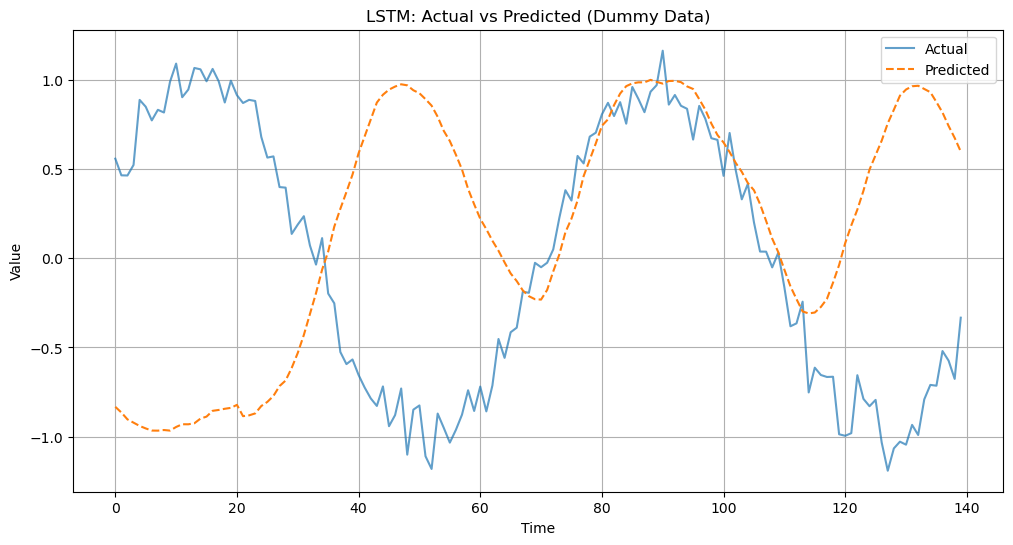

In [9]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.append(output.item())
        actuals.append(y_batch.item())

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", alpha=0.7)
plt.plot(predictions, label="Predicted", linestyle="--")
plt.title("LSTM: Actual vs Predicted (Dummy Data)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


The LSTM captures temporal dependencies in the data by maintaining an internal
memory state. Even with noisy inputs, the model learns the underlying trend
present in the sequence. Including sentiment as a feature allows the model to
incorporate leading indicators alongside historical price behavior.

Note:
Dummy time-series data is used in this notebook to focus on understanding the
LSTM architecture and temporal modeling. In Week 4, this pipeline is extended
to real market data with sentiment features aligned to trading days.